In [1]:
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Add,Concatenate, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10033365430851429047
]


In [2]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [5]:
import os 
os.chdir("C:\\Users\\rohan\\Desktop\\LeadingIndia.ai\\TASK2\\Liar\\liar_dataset")
data_train = pd.read_csv('train.tsv', sep = '\t')
data_valid = pd.read_csv("valid.tsv", sep='\t')
data_test=pd.read_csv("test.tsv",sep='\t')
data_train.head()

data_train.columns = ['id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue']
 
data_valid.columns =['id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue']



data_test = ['id','label','statement','subject','speaker', 'job', 'state','party','barely_true_c','false_c','half_true_c','mostly_true_c','pants_on_fire_c','venue']


df = pd.concat([data_train, data_valid])


data_train.head(5)
data_train.describe()

,barely_true_c,false_c,half_true_c,mostly_true_c,pants_on_fire_c
count,10237.000000,10237.000000,10237.000000,10237.000000,10237.000000
mean,11.534336,13.287682,17.135391,16.435870,6.202012
std,18.974349,24.113808,35.847862,36.153089,16.129599
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [4]:


# Input Data preprocessing

print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
print(data_train.shape)
data_train = data_train.drop(['id','venue'],axis = 1)
print(data_train.shape[0])

texts = []
labels = []

for i in range(data_train.shape[0]):
    text1 = data_train.subject[i]
    text2 = data_train.statement[i]
    text3 = data_train.speaker[i]
    text4 = data_train.job[i]
    text5 = data_train.party[i]
    text = str(text1) +""+ str(text2) +""+ str(text3) +""+ str(text4) +""+ str(text5)
    texts.append(text)
    if data_train.label[i] == 'false' :
      labels.append(0)
    elif data_train.label[i] == 'true' :
      labels.append(1)
    elif data_train.label[i] == 'mostly-true' : 
      labels.append(2)
    elif data_train.label[i] == 'half-true' : 
      labels.append(3)
    elif data_train.label[i] == 'pants-fire' : 
      labels.append(4)
    elif data_train.label[i] == 'barely-true' : 
      labels.append(5)
   
  
print(labels)
print(len(labels))
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state',
       'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'venue'],
      dtype='object')
What the raw input data looks like:
           id        label                                          statement  \
0  10540.json    half-true  When did the decline of coal start? It started...   
1    324.json  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
2   1123.json        false  Health care reform legislation is likely to ma...   
3   9028.json    half-true  The economic turnaround started at the end of ...   
4  12465.json         true  The Chicago Bears have had more starting quart...   

                              subject         speaker  \
0  energy,history,job-accomplishments  scott-surovell   
1                      foreign-policy    barack-obama   
2                         health-care    blog-posting   
3                        economy,jobs   ch

Found 20955 unique tokens.


In [11]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 6)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (10239, 100)
Shape of label tensor: (10239, 6)


In [12]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.05, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.6, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 9727 6144 4095
real & fake news in train,valt,test:
[1892. 1582. 1870. 2000.  798. 1585.]
[1218. 1008. 1142. 1261.  503. 1012.]
[776. 668. 820. 853. 336. 642.]


In [13]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU


In [19]:
#Using Pre-trained word embeddings 
os.chdir("C:\\Users\\rohan\\Desktop\\LeadingIndia.ai")
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [20]:
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(6, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
modell.fit(x_train, y_train, epochs=10, batch_size=64)

modell.save('lstm.h5')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2095600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           16032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)              

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
9727/9727 [==============================] - 10s 998us/step - loss: 0.4455 - accuracy: 0.8333
Epoch 2/10
9727/9727 [==============================] - 9s 973us/step - loss: 0.4392 - accuracy: 0.8333
Epoch 3/10
9727/9727 [==============================] - 10s 985us/step - loss: 0.4325 - accuracy: 0.8332
Epoch 4/10
9727/9727 [==============================] - 9s 965us/step - loss: 0.4251 - accuracy: 0.8334
Epoch 5/10
9727/9727 [==============================] - 10s 978us/step - loss: 0.4150 - accuracy: 0.8338
Epoch 6/10
9727/9727 [==============================] - 10s 983us/step - loss: 0.4003 - accuracy: 0.8333
Epoch 7/10
9727/9727 [==============================] - 10s 980us/step - loss: 0.3836 - accuracy: 0.8352
Epoch 8/10
9727/9727 [==============================] - 10s 984us/step - loss: 0.3633 - accuracy: 0.8370
Epoch 9/10
9727/9727 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.84 - 10s 985us/step - loss: 0.3428 - accuracy: 0.8451
Epoch 10/10
972

In [21]:
embedding_vecor_length = 32
modelg = Sequential()
modelg.add(embedding_layer)
modelg.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
###
modelg.add(BatchNormalization())
###
modelg.add(Dense(6, activation='softmax'))
modelg.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelg.summary())
modelg.fit(x_train, y_train, epochs=2, batch_size=64)
modelg.save('gru.h5')


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2095600   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 2,156,906
Trainable params: 2,156,706
Non-trainable params: 200
_________________________________________________________________
None


C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
9727/9727 [==============================] - 19s 2ms/step - loss: 0.5171 - accuracy: 0.8143
Epoch 2/2
9727/9727 [==============================] - 18s 2ms/step - loss: 0.4788 - accuracy: 0.8271


Correct predictions: 3570.0
Total number of test examples: 4095
Accuracy of model1:  0.8717948717948718


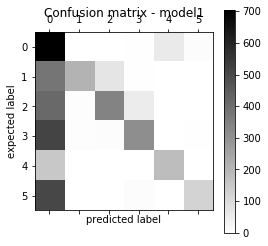

In [22]:
# Test model 1
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modell.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()
#sns.set(font_scale=1.4)#for label size
#sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size


Correct predictions: 3319.0
Total number of test examples: 4095
Accuracy of model1:  0.8105006105006105


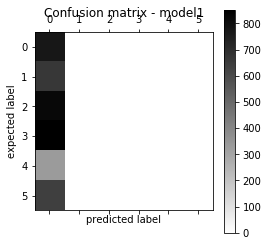

In [23]:
# Test model 2
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modelg.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modelg.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()
#sns.set(font_scale=1.4)#for label size
#sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='f')# font size